In [1]:
import gym
import torch
import numpy as np

In [2]:
import env

Environment closely follows OpenAI gym API. Currently can not be invoked with ```gym.make("env_id")```, though it should be easy to do.

In [11]:
checkers_env = env.Env()

A state is ```(5+NUMBER_OF_PIECES, BOARD_SIZE, BOARD_SIZE) ndarray```

Where

* ```state[0]``` — black pieces
* ```state[1]``` — white pieces
* ```state[2]``` — pieces ids
* ```state[3]``` — current turn (blacks=1, whites=0)
* ```state[4]``` — whether game in terminal state
* ```state[5+i]``` — allowed moves for piece number i

I should probably move allowed moves elsewhere but I have a lot of RAM to keep things unoptimized.


In [43]:
from matplotlib import pyplot as plt

%matplotlib widget 

def show_state(state):
    plt.imshow(state)
    plt.show()

In [46]:
state = checkers_env.current_state()

In [84]:
from matplotlib import colors

def show_board(board):
   cmap = colors.ListedColormap(['white', 'red'])
   bounds=[0,0.5,1]
   norm = colors.BoundaryNorm(bounds, cmap.N)
   plt.figure(figsize=(4,4))
   plt.matshow(board, cmap=cmap, norm=norm, interpolation='none')
   plt.xticks(np.arange(0.5,10.5), [])
   plt.yticks(np.arange(0.5,10.5), [])

   plt.grid()



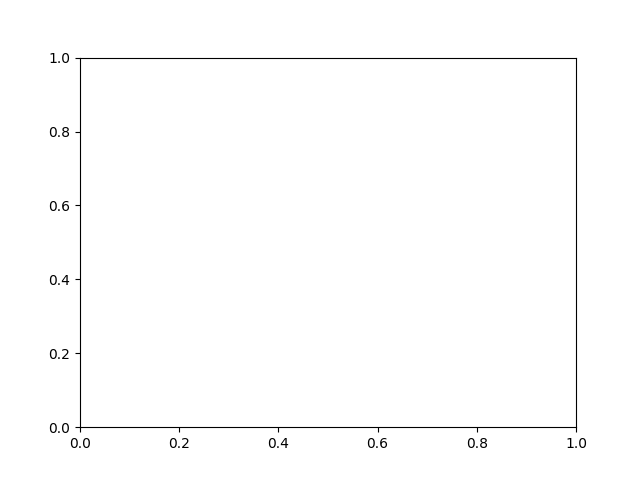

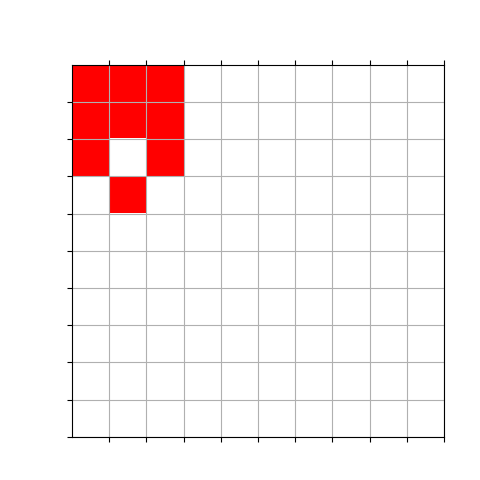

In [87]:
show_board(state[0])